# 4-D-Wave Ocean SDK 入門

D-Wave Ocean SDK(以下、Ocean) は、D-Waveマシンを使用するソフトウェアがまとまっている開発キットです。Pythonから各種機能を簡単に利用することができます。

Github: https://github.com/dwavesystems/dwave-ocean-sdk  
Document: https://docs.ocean.dwavesys.com/en/latest/

インストールするには上にある通り、pipを使用するかgithubのリポジトリをクローンします。

In [ ]:
!pip install dwave-ocean-sdk

In [ ]:
!git clone https://github.com/dwavesystems/dwave-ocean-sdk.git
!cd dwave-ocean-sdk
!python setup.py install

以降では、数分割問題を通して以下の内容について説明していきます。

- QUBOまたはイジングモデルの作り方
- Oceanの使い方
- アニーリングパラメータを変えた場合の最適化

## 定式化

D-Waveマシンに投げることができる形式にはイジングモデルとQUBOがあります。ここでは詳細には触れず、Oceanを使用する上で最低限必要なことを説明します。

### QUBOとイジングモデル

#### QUBO

QUBOの場合、2値変数(バイナリ変数)$q_{i} \in \{0, 1\}$に対して、以下のハミルトニアンを考えます。

$$
H\left(\left\{q_{i}\right\}\right)= \sum_{i} Q_{i i} q_{i} + \sum_{i>j} Q_{i j} q_{i} q_{j}
$$

QUBOを解く際には、上の式の$Q_{i i}$と$Q_{i j}$を古典コンピュータで計算し、D-Waveマシンに与えることになります。

#### イジングモデル

イジングモデルの場合、2値変数$\sigma_{i} \in \{1, -1\}$に対して、以下のハミルトニアンを考えます。

$$
H\left(\left\{\sigma_{i}\right\}\right)=\sum_{i} h_{i} \sigma_{i} + \sum_{i>j} J_{i j} \sigma_{i} \sigma_{j}
$$

イジングモデルを解く際には、上の式の$h_{i}$と$J_{i j}$を古典コンピュータで計算し、D-Waveマシンに与えることになります。

#### 相互変換

QUBOとイジングモデルは、$q_{i} = (\sigma_{i} + 1) / 2$という変換式によって相互変換が可能です。  
この点において、どちらでハミルトニアンを定式化しても問題はないので、対象の問題から考えやすい方を選びましょう。  
ただし同じ問題の2種類の形式に対して、D-Waveマシンの振る舞いが異なる場合があるので注意が必要です。

### 数分割問題

与えられた整数の集合を、2つのグループに分けることを考えます。このとき、各グループの総和が同じになるように分ける問題を数分割問題といいます。  
例として、以下の整数の集合$C$を2つのグループに分けることを目標にしてみましょう。

In [2]:
# 整数の集合を定義します。
C = [2, 10, 3, 8, 5, 7, 9, 5, 3, 2]
N = len(C)

この場合、それぞれの総和の差がゼロになる最適解は23通り存在します(総和の差という名のエネルギーが同じ値ですが、解が違う状態が複数あります。このような状態を物理用語で「縮退している」と呼びます)。  
例えば、$\{2,5,3,10,7\}, \{2,5,3,9,8\}$(総和はどちらも27)があります。

#### QUBO

2つのグループの総和の差を0にすることを目指して、定式化を行いましょう。

<p style="text-align: center">グループAに属する数字の総和 - グループBに属する数字の総和 = 0</p>

そこで2値変数(バイナリ変数)$q_{i}$を用意し、$i$番目の数字がグループAに属する場合$q_{i} = 0$、グループBに属する場合$q_{i} = 1$と定義します。このときグループAに属する数字の総和は$\sum_{i=1}^{N}c_{i}q_{i}$、グループBに属する数字の総和は$\sum_{i=1}^{N}c_{i}(1 - q_{i})$と表されるので、先ほどの式は

$$\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)=0$$

となります。この等式が成り立つように問題を解きたいと考えるので、この式は`制約`を表していることがわかります。このような等式制約を素直に表現する場合には、罰金法が用いられます。

> (罰金法) 最小化したいコスト(目的関数)を$f(x)$、制約条件を$g(x) = 0$とすると、ハイパーパラメータ$\lambda$を用いて以下の項を追加して最適化問題を解くことを罰金法と呼びます。  
> $$\min_{x} \left\{ f(x) + \lambda g(x)^2\right\}$$

よって、数分割問題に対するQUBOは以下のようになります。

$$
H\left(\left\{q_{i}\right\}\right)=\left(\sum_{i=1}^{N} c_{i} q_{i}-\sum_{i=1}^{N} c_{i}\left(1-q_{i}\right)\right)^{2}
$$

D-Waveマシンに問題を投げるためには$Q_{i j}$の値を求める必要があります。そのために$H\left(\left\{\sigma_{i}\right\}\right)$を展開し、整理をしましょう。

$$
H\left(\left\{q_{i}\right\}\right)=\left(2\sum_{i=1}^{N} c_{i} q_{i} - \sum_{i=1}^{N} c_{i} \right)^{2} =4 \sum_{i=1}^{N} c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right) q_{i}+8 \sum_{i=1}^{N} \sum_{j=i+1}^{N} c_{i} c_{j} q_{i} q_{j}+\left(\sum_{i=1}^{N} c_{i}\right)^{2}
$$

よって

$$Q_{i i} = 4 c_{i} \left( c_{i} - \sum_{j=1}^{N} c_{j}\right)$$
$$Q_{i j} = 8 c_{i} c_{j}$$

となります。

> 一番最後の項は$\{ q_i\}$に依存しない定数であるため、ハミルトニアン$H (\{ q_i\})$を最小化する$\{ q_i\}$の組み合わせを探す上では無視しても問題ありません。

In [6]:
# 上で求めたQ_{ii}, Q_{ij}を{(i, j): Q_{ij}}のような辞書型で定義します。
Q = {}
for i in range(N):
    Q[i, i] = 4 * C[i] * (C[i] - sum(C))
    for j in range(i + 1, N):
        Q[i, j] = 8 * C[i] * C[j]

結合の度合いや係数比など対象の問題を理解するために、QUBOを可視化してみましょう。

In [7]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def show_qubo(qubo, cmap=cm.GnBu, save_path=None):
    n_qubo = max(sorted(qubo.keys())[-1][0], sorted(qubo.keys(), key=lambda x: x[1])[-1][1]) + 1

    np_qubo = np.zeros((n_qubo, n_qubo))
    for (pos_x, pos_y), coeff in qubo.items():
        np_qubo[pos_x][pos_y] = coeff

    plt.imshow(np_qubo, cmap=cmap)
    plt.colorbar()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

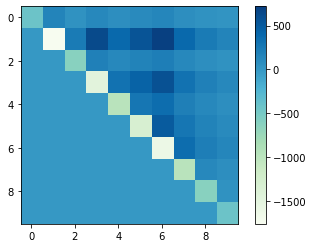

In [9]:
show_qubo(Q)

対角成分が$Q_{i i}$、非対角成分が$Q_{i j}$です。定式化の時点から明らかですが、数分割問題は全ての量子ビット間に相互作用が存在する、全結合の問題であることが分かります。

#### イジングモデル

イジングモデルとQUBOの相互変換の式から、数分割問題をイジングモデルで表すと以下のような簡潔な式で表されます。

$$
H\left(\left\{\sigma_{i}\right\}\right) = \left(\sum_{i} c_{i} \sigma_{i}\right)^2
$$

QUBOと同様に、D-Waveマシンに問題を投げるためには$h_{i}$と$J_{i j}$の値が必要です。$\sigma_{i}^2 = 1$であることに注意して、$H\left(\left{\sigma_{i}\right\}\right)$を展開しましょう。

$$
H\left(\left\{\sigma_{i}\right\}\right) = \sum_{i} c_{i}^2 \sigma_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j} = \sum_{i} c_{i}^2 + 2 \sum_{i < j} c_{i} c_{j} \sigma_{i} \sigma_{j}
$$

よって

$$h_{i} = 0$$

$$J_{i j} = 2 c_{i} c_{j}$$

となります。

> QUBOでの議論と同様に、定数項は無視します。

In [10]:
# h_iとJ_ijを定義します。
h = {}
J = {}
for i in range(N):
    h[i] = 0
    for j in range(i + 1, N):
        J[i, j] = 2 * C[i] * C[j]

ちなみに、Oceanの基本的なライブラリであるdimodの.BinaryQuadraticModel()を用いることで、イジングモデルとQUBOの相互変換が可能です。

- .BinaryQuadraticModel(linear, quadratic, offset, vartype)
    * linear: dict, h_i(もしくはQ_{ii})を辞書型で入れます。
    * quadratic: dict, J_ij(もしくはQ_{ij})を辞書型で入れます。
    * offset: number, 変換する際のエネルギーオフセットを指定します。
    * vartype: インプットとして入れる変数がイジングモデルの場合は'SPIN'を、QUBOの場合は'BINARY'を指定します。

In [14]:
import dimod

In [15]:
# イジングモデルからQUBOへの変換を行います。
model = dimod.BinaryQuadraticModel(h, J, 0.0, vartype='SPIN')
qubo, offset = model.to_qubo()

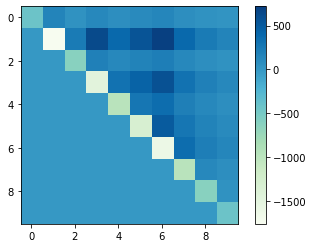

In [16]:
show_qubo(qubo)

ここまで、$Q_{i i}, Q_{i j}$や$h_{i}, J_{i j}$といった係数行列を求めるために、構成したハミルトニアンを展開しました。しかし、より複雑なハミルトニアンを扱う場合には手計算がより複雑になり、計算ミスが生じる可能性があります。  
そこで、(株)リクルートコミュニケーションズが開発しているドメイン固有言語**PyQUBO**を用いることで、ハミルトニアンを展開することなくQUBOやイジングモデルを作成する事ができます。PyQUBOの使い方については以下のドキュメントを参照ください。

* Github: https://github.com/recruit-communications/pyqubo  
* Document: https://pyqubo.readthedocs.io/en/latest/
* OpenJijTutorial: https://github.com/OpenJij/OpenJijTutorial/blob/master/3-PyQUBO_2_OpenJij.ipynb  
* Qiita: https://qiita.com/ynntech/items/fcfe7caf49f6a8eb3c53

## D-Waveマシンによる最適化

それでは上記の数分割問題を、D-Waveマシンを用いて最適化することを考えましょう。このチュートリアルでは、(1)単純に解く場合 (2)読み取り回数を変えた場合、 (3)アニーリング時間を変えた場合を見てみます。

### イジングモデルを解く

D-WaveマシンのサンプラーはDWaveSampler()、さらに問題をD-Waveマシンのキメラグラフに埋め込むためにEmbeddingComposite()を使用します。

In [90]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [91]:
# 接続情報をオプションとして渡す場合は以下のようにします。
endpoint = 'https://cloud.dwavesys.com/sapi'
token = '##########'
solver = 'DW_2000Q_VFYC_5'

# DWaveSamplerを用います。
dw = DWaveSampler(endpoint=endpoint, token=token, solver=solver)
# キメラグラフに埋め込みを行います。
sampler = EmbeddingComposite(dw)

In [107]:
# イジングモデルの場合は以下を使用します。
response = sampler.sample_ising(h, J, num_reads=100)

# QUBOの場合は以下を使用します。
# response = sampler.sample_qubo(Q, num_reads=100)

得られた結果を確認してみましょう。解の状態、エネルギー、その状態の発生回数、D-Waveマシンのグラフにおいて壊れたチェーンの割合を.recordで見ることができます。

In [108]:
response.record

rec.array([([ 1, -1,  1,  1,  1,  1, -1,  1,  1, -1], -226., 1, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1,  1,  1],   30., 2, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 1, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 2, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1, -1,  1], -174., 1, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([-1,  1, -1,  1,  1, -1,  1, -1,  1,  1],   30., 2, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([ 1, -1,  1, -1,  1,  1, -1,  1, -1, -1], -270., 1, 0.8),
           ([ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1], -174., 1, 0.8),
           ([-1,  1,  1,  1, -1, -1,  1, -1,  1,  1], -114., 1, 0.8),
           ([-1,  1,  1,  1,  1, -1,  1, -1, -1,  1],   30., 1, 0.8),
           ([ 1, -1,  1, -1,  1,  1, -1,  1, -1, -1], -270., 1, 0.8),
           ([-1,  1, -1,  1, -1, -1,  1, -1,  1,  1], -270., 2, 0.8),
           ([-1,  1,

この中に最適解がどのくらい含まれているかを調べてみましょう。ここでは最適解かどうかを判別するために、それぞれの解のエネルギー値を求めます。

In [109]:
def calcurate_energy(solution, vartype='BINARY'):
    if vartype == 'BINARY':
        ene = sum(C) ** 2  # offset
        for i in range(N):
            ene += Q[i, i] * solution[i]
            for j in range(i + 1, N):
                ene += Q[i, j] * solution[i] * solution[j]
    elif vartype == 'SPIN':
        ene = sum(C[i] ** 2 for i in range(N))
        for i in range(N):
            for j in range(i + 1, N):
                ene += J[i, j] * solution[i] * solution[j]
    else:
        raise ValueError("vartype mast be 'BINARY' or 'SPIN'.")

    return ene

In [110]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
twenty_sol = []
for state in response.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='SPIN')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # 20 µsの結果を保存しておきます(あとで使用します)。
    twenty_sol.append(solution)

In [111]:
num_optimal_sol

3

最適解が重複を含めて3個得られました。2つのグループは以下のようになっています。

In [113]:
for solution in optimal_sol:
    group_A = [C[i] for i, s in enumerate(solution) if s==1]
    group_B = [C[i] for i, s in enumerate(solution) if s==-1]
    print(solution)
    print('Group A: ', group_A, ', Sum = ', sum(group_A))
    print('Group B: ', group_B, ', Sum = ', sum(group_B))

[ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A:  [2, 8, 5, 7, 5] , Sum =  27
Group B:  [10, 3, 9, 3, 2] , Sum =  27
[-1  1  1 -1 -1 -1  1 -1  1  1]
Group A:  [10, 3, 9, 3, 2] , Sum =  27
Group B:  [2, 8, 5, 7, 5] , Sum =  27
[ 1 -1 -1  1  1  1 -1  1 -1 -1]
Group A:  [2, 8, 5, 7, 5] , Sum =  27
Group B:  [10, 3, 9, 3, 2] , Sum =  27


2つのグループの総和がいずれも等しい、最適解を得ることができました。  
また、D-Waveマシンから返される結果には、解以外にも様々な情報が含まれています。詳細は[SampleSet](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html#dimod.SampleSet)のドキュメントを参照してください。

`data_vectors`ではエネルギー、状態の出現回数、D-Waveマシンのグラフにおいて壊れたチェーンの割合のみをリストで確認することができます。

In [114]:
response.data_vectors

{'energy': array([-226.,   30., -270., -270., -174., -174.,   30., -174., -270.,
        -174., -114.,   30., -270., -270., -270., -174., -114., -334.,
          30., -270., -114.,  206., -114., -366., -366.,   30., -354.,
         306., -366.,   30.,   30., -306., -270., -354.,   30., -270.,
        -366.,   30., -114., -114., -354., -334.,   30., -306.,   30.,
        -354., -354., -366., -306., -366., -354., -270.,   30., -354.,
         306., -334., -366., -366., -370., -366., -354., -366., -270.,
        -370., -306., -370., -306., -366., -334.,   30., -334., -270.]),
 'num_occurrences': array([1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 1, 2,
        2, 1, 1, 3, 1, 1, 1, 3, 1, 4, 1, 2, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 'chain_break_fraction': array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
        0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0

`info`では実行時のQPU(Quantum Processing Unit)に関する情報の一覧を確認することができます。

In [115]:
response.info

{'timing': {'qpu_sampling_time': 31496,
  'qpu_anneal_time_per_sample': 20,
  'qpu_readout_time_per_sample': 274,
  'qpu_access_time': 40886,
  'qpu_access_overhead_time': 2407,
  'qpu_programming_time': 9390,
  'qpu_delay_time_per_sample': 21,
  'total_post_processing_time': 1355,
  'post_processing_overhead_time': 1355,
  'total_real_time': 40886,
  'run_time_chip': 31496,
  'anneal_time_per_run': 20,
  'readout_time_per_run': 274},
 'problem_id': '7a565c51-5378-430b-a5d3-c957cf832d02'}

### 読み取り回数を変えてみる

次に、読み取り回数を変えた場合に得られる解がどのように変わるかを見てみましょう。  
sample_ising()またはsample_qubo()の`num_reads`に値を設定することで、読み取り回数を指定できます。  
num_readsのデフォルト値は1です。先ほどは100回でしたので、今度は1000回で実行してみましょう。

In [122]:
# イジングモデルの場合は以下を用います。
response = sampler.sample_ising(h, J, num_reads=1000)

# QUBOの場合は以下を用います。
# response = sampler.sample_qubo(Q, num_reads=1000)

In [123]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
for state in response.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='SPIN')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)

In [124]:
num_optimal_sol

77

読み取り回数を増やすことで、得られた最適解の個数が増加しました。一方で、アニーリング時間(1回のアニーリングに要する時間)が20$\mu s$ (デフォルト値)と短いため、読み取り回数を増加させても実時間はそれほど差はありません。

In [125]:
response.info

{'timing': {'qpu_sampling_time': 314960,
  'qpu_anneal_time_per_sample': 20,
  'qpu_readout_time_per_sample': 274,
  'qpu_access_time': 324337,
  'qpu_access_overhead_time': 1875,
  'qpu_programming_time': 9377,
  'qpu_delay_time_per_sample': 21,
  'total_post_processing_time': 18907,
  'post_processing_overhead_time': 18907,
  'total_real_time': 324337,
  'run_time_chip': 314960,
  'anneal_time_per_run': 20,
  'readout_time_per_run': 274},
 'problem_id': 'ac673401-ba8e-4a86-a7ef-b9037f882250'}

### アニーリング時間を変えてみる

最後に、アニーリング時間を変えた場合に得られる解がどのように変わるかを見てみましょう。
sample_ising()またはsample_qubo()の`annealing_time`に値を設定することで、アニーリング時間を指定できます(単位は$\mu s$)。先ほどはデフォルト値の20$\mu s$で実行しました。今度は50$\mu s$でアニーリングを行なってみましょう。

In [126]:
# イジングモデルの場合は以下を用います。
response = sampler.sample_ising(h, J, num_reads=100, annealing_time=50)

# QUBOの場合は以下を用います。
# response = sampler.sample_qubo(Q, num_reads=100, annealing_time=50)

In [127]:
# 最適解が出た回数を数え上げます。
num_optimal_sol = 0
optimal_sol = []
fifty_sol = []
for state in response.record:
    # .recordの0番目が状態のリスト、2番目がその状態の出現回数です。
    solution = state[0]
    num_oc = state[2]
    # エネルギーを計算します。
    energy = calcurate_energy(solution, vartype='SPIN')
    # エネルギー(総和の差)が0のときを数え上げます。
    if energy == 0.0:
        num_optimal_sol += num_oc
        optimal_sol.append(solution)
    # 50µsでの実行結果を保存します。
    fifty_sol.append(solution)

In [128]:
num_optimal_sol

6

最適解の回数が劇的に増えたようには見えません。そこでアニーリング時間を変えたことで、得られた解に何か違いがないか調べてみます。ここでは、解のエネルギーのヒストグラムを見てみましょう。

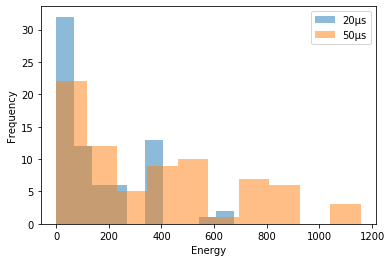

In [129]:
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in twenty_sol], alpha=0.5, label='20μs')
plt.hist([calcurate_energy(solution, vartype='SPIN') for solution in fifty_sol], alpha=0.5, label='50μs')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

上のヒストグラムから、アニーリング時間を増加させたことで得られた最適解の個数は減少しましたが、低いエネルギーの解を多く見つけていることが分かります。ただし、アニーリング時間を大きくすればいいという単純な話ではありません。アニーリング時間が小さい場合の方が最適化がうまくいくこともあり、その依存関係はそれぞれの問題に依ります。  
また、量子アニーリングをはじめとするアニーリング法はメタヒューリスティックスなアルゴリズムであるため、実行するたびに得られる結果は異なる点にも注意しましょう。

## 結言

数分割問題の最適化を通して、D-Wave Oceanの使い方を紹介しました。このチュートリアルで説明したことを押さえるだけでも、様々なことができるようになります。例えば、以下のことを調べられるでしょう。

- 読み取り回数、アニーリングタイムに対する成功確率(最適解が得られる割合)
- 読み取り回数、アニーリングタイムに対するエネルギー値
- 複数の最適解が存在する数分割問題に対して、得られる最適解の割合

2019年4月現在、1ヶ月1分間無料でD-Waveマシンを利用することができます。ぜひ利用して、上の項目について実験してみてください。

D-Wave Leap: https://cloud.dwavesys.com/leap/

このチュートリアルでは触れることができませんでしたが、他にもアニーリングパラメータが存在します。例えば、アニーリングのスケジュールを指定することで、リバースアニーリングなど通常のアニーリングとは異なる手法を実行することができます。気になった方は、D-Waveのドキュメントを読んでみてください。